# SMC-ABC Lotka–Volterra example

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(2)
data = np.random.normal(loc=0, scale=1, size=1000)

# Lotka–Volterra
In this example we will try to find parameters for the Lotka-Volterra equations. A common competition model for describing how the number of individuals of each species changes when more than one species uses the same resource (Otto, Day, 2007).

In [2]:
from scipy.integrate import odeint

In [3]:
# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75

X0 = [10., 5.]
size = 1000
time = 15
t = np.linspace(0, time, size)

def dX_dt(X, t, a, b, c, d):
    """ Return the growth rate of fox and rabbit populations. """

    return np.array([ a*X[0] -   b*X[0]*X[1] , 
                  -c*X[1] + d*b*X[0]*X[1] ])

In [4]:
def simulate(a, b): 
    return odeint(dX_dt, y0=X0, t=t, rtol=0.1, args=(a, b, c, d))

In [5]:
def add_noise(a, b, c, d):
    noise = np.random.normal(size=(size, 2))
    simulated = simulate(a, b)
    simulated += noise
    indexes = np.sort(np.random.randint(low=0, high=size, size=size))    
    return simulated[indexes]

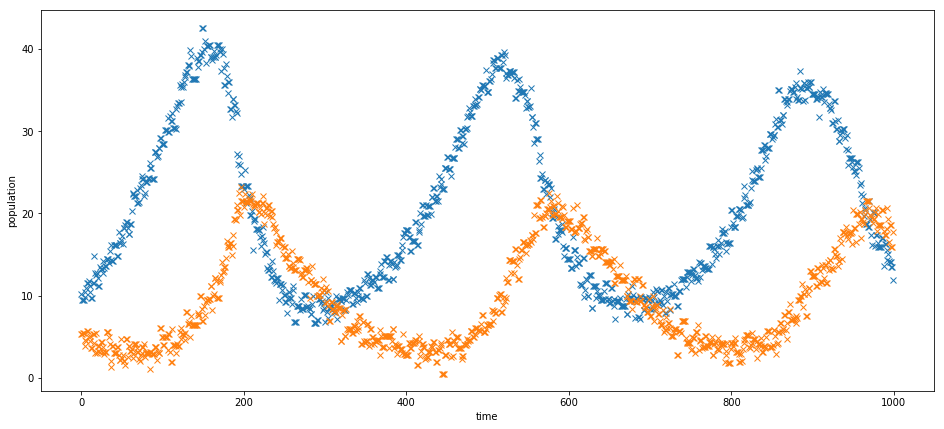

In [6]:
observed = add_noise(a, b, c, d )
_, ax = plt.subplots(figsize=(16,7))
ax.plot(observed, 'x')
ax.set_xlabel('time')
ax.set_ylabel('population');

The epsilons thresholds and prior distributions are specified after (Toni, T., 2008).

In [7]:
with pm.Model() as model:
    
    a = pm.Uniform('a', -10, 10, transform=None)
    b = pm.Uniform('b', -10, 10, transform=None)

    simulator = pm.Simulator('simulator', simulate, observed=observed)
    trace = pm.sample(step=pm.SMC_ABC(epsilons=[30, 16, 6, 5], 
                                      min_epsilon=4.3, tune=False), 
                      draws=200)

/home/agustina/Documents/pymc3/pymc3/step_methods/smc_ABC.py:76: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Using absolute difference as distance metric
Sample initial stage: ...
Sampling stage 0 with Epsilon 30.000000
  0%|          | 0/200 [00:00<?, ?it/s]/home/agustina/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 19%|█▉        | 38/200 [00:01<00:04, 37.61it/s]/home/agustina/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████| 200/200 [00:04<00:00, 40.35it/s]
Sampling stage 1 wit

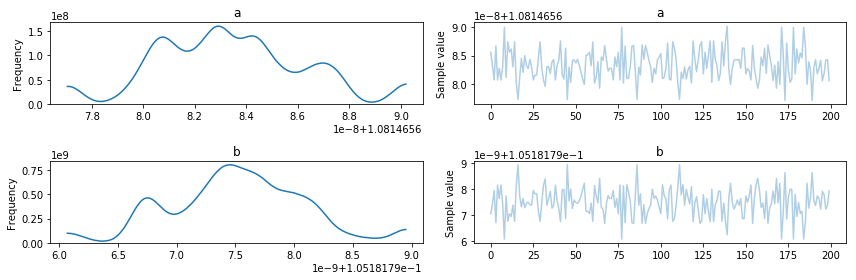

In [8]:
pm.traceplot(trace);

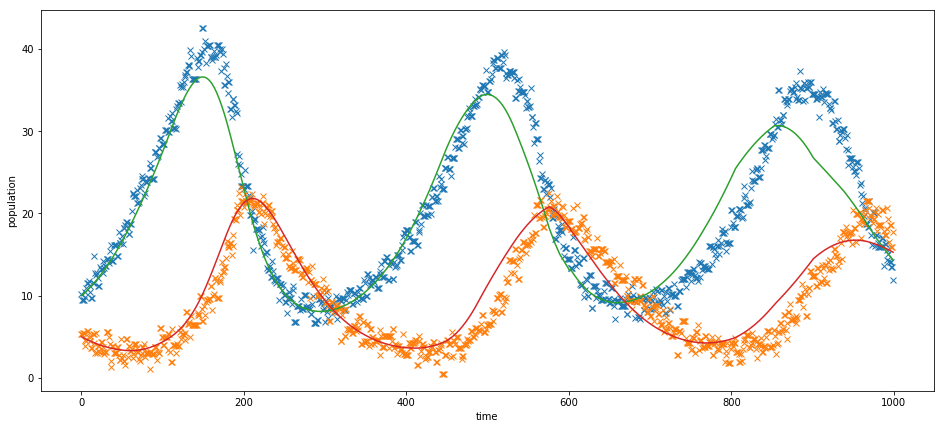

In [10]:
_, ax = plt.subplots(figsize=(16,7))
ax.plot(observed, 'x')
ax.plot(simulate(trace['a'].mean(), trace['b'].mean()))
ax.set_xlabel('time')
ax.set_ylabel('population');

In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,1.081466,2.693079e-09,1.849678e-10,1.081466,1.081466
b,0.105182,5.591987e-10,3.842706e-11,0.105182,0.105182
